# Autolabelling Pipeline

Want to:
- Create a set of functions for autolabelling
    - E.g. pass a folder of raw images and create a labels file for them
- Make a set of zero-shot classification functions with CLIP/BLIP to label images with several parameters:
    - "edible_food" vs "other"
    - "contains_logo" vs "no_logo"
    - "contains_text" vs "no_text"
    - "contains_human" vs "no_human"
    - "apple", "banana"... etc (for different food classes)
- Want to do this to create a very large dataset of *only* food images 

In [1]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

import torch

from utils.misc import sort_dict_by_values

In [2]:
from zero_shot_classification import open_clip_compute_image_features_of_list, open_clip_compute_text_features, open_clip_zero_shot_classification


/home/daniel/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/daniel/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowIlEET_S2_S2_b
  warn(f"Failed to load image Python extension: {e}")


In [3]:
# Get list of all paths in food_photos directory
path = Path('food_photos')
all_paths = list(path.glob('*/*.jpeg'))
all_paths[:10]

[PosixPath('food_photos/cashews/96237783-2f60-4f2d-983a-f1b289067887.jpeg'),
 PosixPath('food_photos/cashews/3ab541fe-7b51-4382-acaa-98e895dd995f.jpeg'),
 PosixPath('food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da4054f6d03f.jpeg'),
 PosixPath('food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b7a9cf66600.jpeg'),
 PosixPath('food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f25a15241af.jpeg'),
 PosixPath('food_photos/orange_juice/64eaaf1b-6e71-4511-8ecb-d3a38c06a3d6.jpeg'),
 PosixPath('food_photos/orange_juice/fa15a4e4-63b2-4491-88fa-095301c34fe0.jpeg'),
 PosixPath('food_photos/grapes_red/ab2835cd-0437-4be2-8ba9-af9f83a5552d.jpeg'),
 PosixPath('food_photos/grapes_red/8f5f13fe-2faa-4b02-b8a8-5690a28ad429.jpeg'),
 PosixPath('food_photos/grapes_red/3d66e684-4f4a-413e-8768-9ee0226df0ad.jpeg')]

In [4]:
# Get the text features (only need to do this once)
import json
with open("class_dict.json", "r") as f:
    class_dict = json.load(f)

class_names = list(class_dict.values())
class_names_and_other = class_names + ["other"]

text_features = open_clip_compute_text_features(class_names_and_other)

food_photos/pear/69a6c532-410b-4332-90cc-ead80ec22822.jpeg


Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

[('pear', 0.9947691559791565), ('guava', 0.0033703302033245564), ('figs', 0.001259400392882526), ('lemon', 6.99489755788818e-05), ('kiwi_fruit', 6.469222716987133e-05)]


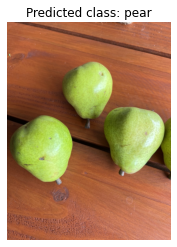

In [19]:
import random
image_path_test = random.choice(all_paths)
print(image_path_test)

from utils.misc import open_image
image = open_image(image_path_test)

# Get the image features
image_feature_dict = open_clip_compute_image_features_of_list([image_path_test])

# Get the zero shot classification
zero_shot_classification = open_clip_zero_shot_classification(image_feature_dict[0]["image_features"], text_features, class_names)

# Get the top 5 predictions
top_5 = sorted(zero_shot_classification.items(), key=lambda x: x[1], reverse=True)[:5]

# Plot the image with the predicted class
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis(False)
plt.title(f"Predicted class: {top_5[0][0]}")
print(top_5)

In [20]:
# Pre-compute features of all images in list (to save computing on the fly, can then just do index-matching)
open_clip_image_features_list = open_clip_compute_image_features_of_list(image_paths=all_paths, device="cuda")

Computing OpenCLIP image features:   0%|          | 0/1381 [00:00<?, ?it/s]

In [21]:
from typing import List
from tqdm.auto import tqdm

def open_clip_get_image_and_text_similarity_dicts(image_paths: list,
                                                  target_classes: List[str]):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    # img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    # blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_compute_text_features(text=target_classes)
    
    # Loop through image paths
    auto_created_labels = []
    for image_path in tqdm(image_paths, desc="Calculating image features and similarity dicts"):

        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = open_clip_image_features_list[image_paths.index(image_path)]["image_features"]
        # blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        # blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # # Average the values of the similarity dicts
        # avg_similarity_dict = {}
        # for key in open_clip_similarity_dict.keys():
        #     avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # # Sort the average similarity dict and reduce length to 5
        # avg_similarity_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is over 5, shorten to only get top 5
        if len(open_clip_similarity_dict) > 5:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:5])
        
        # if len(blip_similarity_dict) > 5:
        #     blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    # "blip_sorted_similarity_dict": blip_similarity_dict,
                                    # "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    # "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    # "avg_sorted_similarity_dict": avg_similarity_dict,
                                    # "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    # "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]
                                })
    
    return auto_created_labels

In [22]:
open_clip_zero_shot = open_clip_get_image_and_text_similarity_dicts(image_paths=all_paths, target_classes=class_names)


Calculating image features and similarity dicts:   0%|          | 0/1381 [00:00<?, ?it/s]

In [23]:
# Turn open_clip_zero_shot into a dataframe
open_clip_zero_shot_df = pd.DataFrame(open_clip_zero_shot)

# Add the class name to the dataframe
open_clip_zero_shot_df["true_label"] = open_clip_zero_shot_df["image_path"].apply(lambda x: str(x).split("/")[-2])

open_clip_zero_shot_df.head()

,image_path,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score,true_label
0,food_photos/cashews/96237783-2f60-4f2d-983a-f1...,"{'cashews': 0.9854564070701599, 'nuts': 0.0145...",cashews,0.985456,cashews
1,food_photos/cashews/3ab541fe-7b51-4382-acaa-98...,"{'cashews': 0.9960439205169678, 'nuts': 0.0039...",cashews,0.996044,cashews
2,food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...,"{'cashews': 0.9985688924789429, 'nuts': 0.0014...",cashews,0.998569,cashews
3,food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...,"{'cashews': 0.9954507946968079, 'nuts': 0.0045...",cashews,0.995451,cashews
4,food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...,"{'cashews': 0.9988252520561218, 'nuts': 0.0011...",cashews,0.998825,cashews


In [27]:
# See if the top 1 class name matches the class name
open_clip_zero_shot_df["correct"] = open_clip_zero_shot_df["open_clip_top_1_class_name"] == open_clip_zero_shot_df["true_label"]

# How many correct?
open_clip_zero_shot_df["correct"].sum()

# What percentage correct?
open_clip_zero_shot_df["correct"].sum() / len(open_clip_zero_shot_df)

0.8580738595220855

In [28]:
(open_clip_zero_shot_df["open_clip_top_1_class_name"] == open_clip_zero_shot_df["true_label"]).sum() / len(open_clip_zero_shot_df)

0.8580738595220855

In [29]:
# Show rows where the top 1 class name does not match the class name
open_clip_zero_shot_df[open_clip_zero_shot_df["correct"] == False]

,image_path,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score,true_label,correct
6,food_photos/orange_juice/fa15a4e4-63b2-4491-88...,"{'fruit_juice': 0.5023571848869324, 'orange_ju...",fruit_juice,0.502357,orange_juice,False
182,food_photos/steak/453c3d46-0412-4567-a070-ef97...,"{'chimichurri': 0.9282695055007935, 'steak': 0...",chimichurri,0.928270,steak,False
189,food_photos/lychee/e87a9984-5455-4efc-9f28-d35...,"{'chilli': 0.1187906265258789, 'potato_brown':...",chilli,0.118791,lychee,False
191,food_photos/lychee/20519ff4-8ecf-4126-a514-947...,"{'onion_white': 0.6689971685409546, 'mandarin'...",onion_white,0.668997,lychee,False
200,food_photos/lychee/6d49671c-e25a-45c9-acea-9b0...,"{'chilli': 0.13156960904598236, 'lychee': 0.11...",chilli,0.131570,lychee,False
...,...,...,...,...,...,...
1371,food_photos/tea/1f46a92a-d5a5-468f-b982-6a4d23...,"{'hot_chocolate': 0.5215670466423035, 'tea': 0...",hot_chocolate,0.521567,tea,False
1372,food_photos/tea/3108aa69-9a6a-44cc-b2e8-bd52d6...,"{'hot_chocolate': 0.8796043992042542, 'coffee'...",hot_chocolate,0.879604,tea,False
1374,food_photos/tea/b1e8a40f-ae3e-4b18-a45d-69c2a5...,"{'shallots': 0.8734229207038879, 'onion_red': ...",shallots,0.873423,tea,False
1375,food_photos/tea/20df8dbb-53c0-441e-910a-b69b08...,"{'hot_chocolate': 0.8619011640548706, 'coffee'...",hot_chocolate,0.861901,tea,False


In [37]:
# Find the value counts of the top 1 class name
open_clip_zero_shot_df["open_clip_top_1_class_name"].value_counts()

grapes_red         165
broccolini         155
pear               146
fennel             135
lychee             132
leek               132
parsley            126
corn               111
chilli             111
tomato              29
celery              15
onion_green         15
onion_white         11
banana               8
radish               5
cashews              5
cherries             4
brussel_sprouts      4
shallots             4
grapes_white         4
steak                4
potato_scallop       3
garlic               3
hot_chocolate        3
carrot               3
grapes_black         3
ice_coffee           3
nuts                 3
onion_brown          2
coriander            2
capsicum             2
red_wine             2
onion_red            2
milk                 2
fruit_smoothie       2
eggs                 2
prosciutto           1
tea                  1
guava                1
green_beans          1
cauliflower          1
fruit_juice          1
maple_syrup          1
biltong    

In [39]:
wrong_preds_new = open_clip_zero_shot_df[open_clip_zero_shot_df["open_clip_top_1_class_name"] != open_clip_zero_shot_df["true_label"]][["image_path", "true_label", "open_clip_top_1_class_name", "open_clip_top_1_similarity_score", "open_clip_sorted_similarity_dict"]]
wrong_preds_new

,image_path,true_label,open_clip_top_1_class_name,open_clip_top_1_similarity_score,open_clip_sorted_similarity_dict
6,food_photos/orange_juice/fa15a4e4-63b2-4491-88...,orange_juice,fruit_juice,0.502357,"{'fruit_juice': 0.5023571848869324, 'orange_ju..."
182,food_photos/steak/453c3d46-0412-4567-a070-ef97...,steak,chimichurri,0.928270,"{'chimichurri': 0.9282695055007935, 'steak': 0..."
189,food_photos/lychee/e87a9984-5455-4efc-9f28-d35...,lychee,chilli,0.118791,"{'chilli': 0.1187906265258789, 'potato_brown':..."
191,food_photos/lychee/20519ff4-8ecf-4126-a514-947...,lychee,onion_white,0.668997,"{'onion_white': 0.6689971685409546, 'mandarin'..."
200,food_photos/lychee/6d49671c-e25a-45c9-acea-9b0...,lychee,chilli,0.131570,"{'chilli': 0.13156960904598236, 'lychee': 0.11..."
...,...,...,...,...,...
1371,food_photos/tea/1f46a92a-d5a5-468f-b982-6a4d23...,tea,hot_chocolate,0.521567,"{'hot_chocolate': 0.5215670466423035, 'tea': 0..."
1372,food_photos/tea/3108aa69-9a6a-44cc-b2e8-bd52d6...,tea,hot_chocolate,0.879604,"{'hot_chocolate': 0.8796043992042542, 'coffee'..."
1374,food_photos/tea/b1e8a40f-ae3e-4b18-a45d-69c2a5...,tea,shallots,0.873423,"{'shallots': 0.8734229207038879, 'onion_red': ..."
1375,food_photos/tea/20df8dbb-53c0-441e-910a-b69b08...,tea,hot_chocolate,0.861901,"{'hot_chocolate': 0.8619011640548706, 'coffee'..."


In [40]:
# Get the top 100 most wrong examples
most_wrong = wrong_preds_new.sort_values("open_clip_top_1_similarity_score", ascending=False)[:100]
most_wrong

,image_path,true_label,open_clip_top_1_class_name,open_clip_top_1_similarity_score,open_clip_sorted_similarity_dict
416,food_photos/onion_green/c5fd3879-ef0a-454b-a5e...,onion_green,leek,0.993060,"{'leek': 0.9930599927902222, 'onion_green': 0...."
378,food_photos/onion_green/62f79504-b4b6-420b-970...,onion_green,leek,0.992639,"{'leek': 0.9926387071609497, 'onion_green': 0...."
397,food_photos/onion_green/0933d5c6-33b8-46f9-a77...,onion_green,leek,0.991639,"{'leek': 0.9916391968727112, 'onion_green': 0...."
487,food_photos/corn/803b56ae-9b15-4e71-8074-e6406...,corn,leek,0.991277,"{'leek': 0.9912769794464111, 'corn': 0.0023446..."
389,food_photos/onion_green/e68eee55-b64e-4c3f-909...,onion_green,leek,0.991095,"{'leek': 0.9910954236984253, 'celery': 0.00386..."
...,...,...,...,...,...
428,food_photos/onion_green/a4c1e890-cafd-47ac-a2e...,onion_green,leek,0.789351,"{'leek': 0.7893514633178711, 'onion_green': 0...."
364,food_photos/onion_green/18016225-a55d-4448-896...,onion_green,leek,0.778793,"{'leek': 0.7787929177284241, 'onion_green': 0...."
421,food_photos/onion_green/4c5c896d-6b6a-4201-aad...,onion_green,leek,0.777086,"{'leek': 0.7770860195159912, 'onion_green': 0...."
448,food_photos/onion_green/9711c089-03e2-48c2-a1d...,onion_green,leek,0.775355,"{'leek': 0.7753552794456482, 'onion_green': 0...."


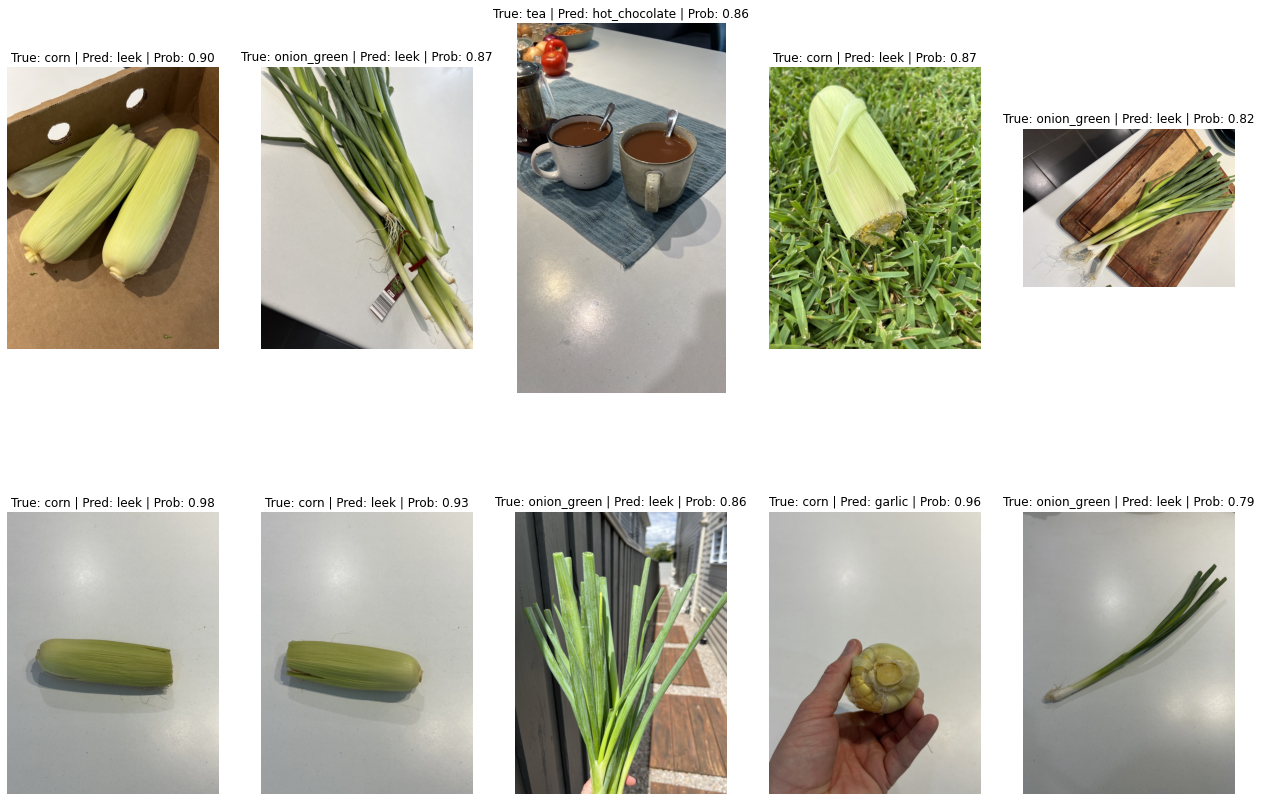

In [58]:
# Plot 10 random examples from most_wrong
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 5, figsize=(22, 15))

# Get 10 random indices
random_indices = np.random.choice(range(len(most_wrong)), size=10, replace=False)

for i in range(10):
    ax[i // 5, i % 5].imshow(plt.imread(most_wrong["image_path"].iloc[random_indices[i]]))
    ax[i // 5, i % 5].set_title(f"True: {most_wrong['true_label'].iloc[random_indices[i]]} | Pred: {most_wrong['open_clip_top_1_class_name'].iloc[random_indices[i]]} | Prob: {most_wrong['open_clip_top_1_similarity_score'].iloc[random_indices[i]]:.2f}")
    ax[i // 5, i % 5].axis(False)


In [3]:
# Next:
# Create functions for zero-shot classifiers
# Go through all the paths apply the zero-shot classifiers
# Add some images which are examples which should be food/not food etc
# The model should pick these up...
# Create labels for the images based on the results of the zero-shot classifiers

In [44]:
import torch
from lavis.models import load_model_and_preprocess
from PIL import Image

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: move to utils.py?
def open_image(image_path_or_PIL):
    try:
        return Image.open(image_path_or_PIL).convert("RGB")
    except:
        return image_path_or_PIL.convert("RGB")

misc_dict = {"chicken": 123,
             "pizza": 456,
             "hot dog": 789}

# TODO: move to utils.py
# Create a function to sort dict by values
def sort_dict_by_values(dict_to_sort):
    sorted_dict = dict(sorted(dict_to_sort.items(), key=lambda x:x[1], reverse=True))
    return sorted_dict
    # return {k: v for k, v in sorted(dict_to_sort.items(), key=lambda item: item[1], reverse=True)}

sort_dict_by_values(misc_dict)

#### BLIP ####

# Start Vision-Language modelling section
blip_feature_extractor_model, vis_processors, txt_processors = load_model_and_preprocess(name="blip_feature_extractor", 
                                                                                         model_type="base", 
                                                                                         is_eval=True, 
                                                                                         device=device)

def blip_get_image_features(image,
                            model=blip_feature_extractor_model, 
                            vis_processors=vis_processors, 
                            device=device,
                            low_dim=True):

    # Make sure model and image are on the same device
    blip_feature_extractor_model.to(device)
                 
    # Preprocess image
    image = vis_processors["eval"](image).unsqueeze(0).to(device)

    # Turn image into sample dict
    sample = {"image": image}

    # Get features
    features_image = model.extract_features(sample, mode="image")

    # Turn features into low-dim
    if low_dim:
        features_image = features_image.image_embeds_proj
    else:
        features_image = features_image.image_embeds

    return features_image

def blip_get_text_features(text: list,
                           model=blip_feature_extractor_model, 
                           txt_processors=txt_processors, 
                           device=device,
                           low_dim=True):
                 
    # Preprocess image
    text_input = [txt_processors["eval"](text) for text in text]

    # Turn image into sample dict
    sample = {"text_input": text_input}

    # Get features
    features_text = model.extract_features(sample, mode="text")

    # Turn features into low-dim
    if low_dim:
        features_text = features_text.text_embeds_proj[:, 0]
    else:
        features_text = features_text.text_embeds[:, 0]

    return features_text.to(device)


### CLIP

### Load CLIP model and create helper functions
clip_feature_extractor_model, clip_vis_processors, clip_txt_processors = load_model_and_preprocess(name="clip_feature_extractor", 
                                                                                                   model_type="ViT-B-16", 
                                                                                                   is_eval=True, 
                                                                                                   device=device)

# Create a function to get CLIP image features
def clip_get_image_features(image, 
                            clip_feature_extractor_model=clip_feature_extractor_model, 
                            clip_vis_processors=clip_vis_processors, 
                            device=device):
    processed_image = clip_vis_processors["eval"](image).unsqueeze(0).to(device)
    sample = {"image": processed_image}
    clip_image_features = clip_feature_extractor_model.extract_features(sample)
    # clip_image_features = clip_features.image_embeds_proj
    return clip_image_features

def clip_get_text_features(text,  clip_feature_extractor_model=clip_feature_extractor_model, clip_txt_processors=clip_txt_processors, device=device):
    text_input = clip_txt_processors["eval"](text)
    sample = {"text_input": [text_input]}
    features_text = clip_feature_extractor_model.extract_features(sample)
    return features_text

# Create a function to get CLIP image features
def clip_get_image_features(image, 
                            clip_feature_extractor_model=clip_feature_extractor_model, 
                            clip_vis_processors=clip_vis_processors, 
                            device=device):
    processed_image = clip_vis_processors["eval"](image).unsqueeze(0).to(device)
    sample = {"image": processed_image}
    clip_image_features = clip_feature_extractor_model.extract_features(sample)
    # clip_image_features = clip_features.image_embeds_proj
    return clip_image_features

def clip_get_text_features(text:list,
                           model=clip_feature_extractor_model,
                           clip_txt_processors=clip_txt_processors,
                           device=device):
    text_input = [clip_txt_processors["eval"](text) for text in text]
    features = model.extract_features({"text_input": text_input})
    return features.to(device)



In [45]:
def blip_zero_shot_classification(image_features, text_features, class_names, blip_model=blip_feature_extractor_model, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    similarity_values = (image_features @ text_features.t())[0] / blip_model.temp
    probabilities = torch.softmax(similarity_values, dim=0).cpu().tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict


def clip_zero_shot_classification(image_features, text_features, class_names, clip_model=clip_feature_extractor_model, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    similarity_values = (image_features @ text_features.T)[0] / 0.01
    probabilities = torch.softmax(similarity_values, dim=0).cpu().tolist() # return values to CPU

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

### OpenCLIP helper functions

In [26]:
import torch
from PIL import Image
import open_clip
from tqdm.auto import tqdm

open_clip_model_name = "ViT-H-14"
open_clip_pretrained = 'laion2b_s32b_b79k' 

open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(open_clip_model_name, pretrained=open_clip_pretrained)
open_clip_tokenizer = open_clip.get_tokenizer(open_clip_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
open_clip_model.to(device);

def open_clip_compute_image_features_of_list(image_paths: list,
                                             open_clip_model=open_clip_model,
                                             open_clip_preprocess=open_clip_preprocess,
                                             device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing OpenCLIP image features"):
        image_feature_dict = {}

        image = open_clip_preprocess(Image.open(image_path)).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            open_clip_model.to(device)
            image_features = open_clip_model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)       

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def open_clip_get_text_features(text: list,
                                    open_clip_model=open_clip_model,
                                    open_clip_tokenizer=open_clip_tokenizer,
                                    device=device):

    text = open_clip_tokenizer(text)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        open_clip_model.to(device)
        text_features = open_clip_model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def open_clip_zero_shot_classification(image_features, text_features, class_names, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        similarity_values = (image_features @ text_features.T)[0] / 0.01
        probabilities = torch.softmax(similarity_values, dim=-1).cpu().tolist() # return values to CPU

        # Create a dict of class names and their probabilities
        class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

## Create lists of binary classifiers for sorting images

In [47]:
food_not_food = ["edible_food", "other"]
logo_not_logo = ["contains_logo", "other"]

In [48]:
# Create BLIP and CLIP features for binary classifiers
blip_food_not_food_features = blip_get_text_features(text=food_not_food, device="cpu")
clip_food_not_food_features = clip_get_text_features(text=food_not_food, device="cpu")
open_clip_food_not_food_features = open_clip_get_text_features(text=food_not_food, device="cpu")

# blip_logo_not_logo_features = blip_get_text_features_of_list(target_list=logo_not_logo, device="cpu")
# clip_logo_not_logo_features = clip_get_text_features_of_list(target_list=logo_not_logo, device="cpu")

In [49]:
blip_food_not_food_features.shape, clip_food_not_food_features.shape, open_clip_food_not_food_features.shape 

(torch.Size([2, 256]), torch.Size([2, 512]), torch.Size([2, 1024]))

In [50]:
blip_get_text_features(text=["pizza", "hot dog", "chicken"], device="cpu").shape

torch.Size([3, 256])

Now let's open each of the images and compute their zero-shot classification details.

In [51]:
def clip_compute_image_features_of_list(image_paths: list,
                                        device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing CLIP image features"):
        image_feature_dict = {}
        image = open_image(image_path)
        image_features = clip_get_image_features(image=image, device=device).to("cpu")

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def blip_compute_image_features_of_list(image_paths: list,
                                        device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing BLIP image features"):
        image_feature_dict = {}
        image = open_image(image_path)
        image_features = blip_get_image_features(image=image, device=device)

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features.cpu() # store image features on CPU to prevent extra memory usage
        image_features_list.append(image_feature_dict)
    
    return image_features_list

### Precompute image features for use later 

Computing image features takes the longest time so compute these first and save them for later.

In [52]:
blip_image_features_list = blip_compute_image_features_of_list(image_paths=all_paths, device="cuda")
# clip_image_features_list = clip_compute_image_features_of_list(image_paths=all_paths, device="cuda") # this results in out of memory errors (the GELU function in OpenAI clip is busted)
open_clip_image_features_list = open_clip_compute_image_features_of_list(image_paths=all_paths, device="cuda")

Computing BLIP image features:   0%|          | 0/1381 [00:00<?, ?it/s]

Computing OpenCLIP image features:   0%|          | 0/1381 [00:00<?, ?it/s]

In [53]:
blip_image_features_list[0]["image_features"].shape
blip_image_features_list[0]["image_features"][:, 0].shape

torch.Size([1, 256])

In [54]:
from typing import List

def get_image_and_text_similarity_dicts(image_paths: list,
                                        target_classes: List[str],):
    
    # Set CLIP and BLIP to use GPU for creating image features if available
    img_feature_device = "cuda" if torch.cuda.is_available() else "cpu"

    # Encode text features on CPU (this is quick even for 100s of classes)
    blip_text_features = blip_get_text_features(text=target_classes, device="cpu") # only get dims for zero-shot classification
    open_clip_text_features = open_clip_get_text_features(text=target_classes, device="cpu")
    
    # Loop through image paths
    auto_created_labels = []
    for image_path in tqdm(image_paths, desc="Calculating image features and similarity dicts"):

        # Match image path to pre-computed image features
        # print(image_paths.index(image_path))
        open_clip_img_features = open_clip_image_features_list[image_paths.index(image_path)]["image_features"]
        blip_img_features = blip_image_features_list[image_paths.index(image_path)]["image_features"][:, 0] # TODO: could the indexing be cleaner?
        
        # Get sorted similarity dicts
        open_clip_similarity_dict = open_clip_zero_shot_classification(open_clip_img_features, open_clip_text_features, target_classes, sorted=True)
        blip_similarity_dict = blip_zero_shot_classification(blip_img_features, blip_text_features, target_classes, sorted=True)

        # Average the values of the similarity dicts
        avg_similarity_dict = {}
        for key in open_clip_similarity_dict.keys():
            avg_similarity_dict[key] = (open_clip_similarity_dict[key] + blip_similarity_dict[key]) / 2
        
        # Sort the average similarity dict and reduce length to 5
        avg_similarity_dict = dict(list(sort_dict_by_values(avg_similarity_dict).items())[:5])

        # If the length of the similarity dicts is over 5, shorten to only get top 5
        if len(open_clip_similarity_dict) > 5:
            open_clip_similarity_dict = dict(list(open_clip_similarity_dict.items())[:5])
        
        if len(blip_similarity_dict) > 5:
            blip_similarity_dict = dict(list(blip_similarity_dict.items())[:5])
        
        # Append to list
        auto_created_labels.append({"image_path": image_path,
                                    "blip_sorted_similarity_dict": blip_similarity_dict,
                                    "blip_top_1_class_name": list(blip_similarity_dict.keys())[0],
                                    "blip_top_1_similarity_score": list(blip_similarity_dict.values())[0],
                                    "open_clip_sorted_similarity_dict": open_clip_similarity_dict,
                                    "open_clip_top_1_class_name": list(open_clip_similarity_dict.keys())[0],
                                    "open_clip_top_1_similarity_score": list(open_clip_similarity_dict.values())[0],
                                    "avg_sorted_similarity_dict": avg_similarity_dict,
                                    "avg_top_1_class_name": list(avg_similarity_dict.keys())[0],
                                    "avg_top_1_similarity_score": list(avg_similarity_dict.values())[0]})
    
    return auto_created_labels

In [55]:
# target_classes = ["logo", "no_logo"]
food_labels = sorted(list(set([p.parent.name for p in all_paths])))
food_labels.append("other")

print(food_labels)
       
target_classes = food_labels
zero_shot_labels = get_image_and_text_similarity_dicts(image_paths=all_paths,
                                                       target_classes=target_classes)

['banana', 'biltong', 'blueberries', 'broccolini', 'brussel_sprouts', 'cashews', 'cauliflower', 'celery', 'cherries', 'chilli', 'coriander', 'corn', 'cucumber', 'fennel', 'fruit_smoothie', 'garlic', 'grapes_black', 'grapes_red', 'grapes_white', 'green_beans', 'ice_coffee', 'lemon', 'lychee', 'milk', 'omelette', 'onion_green', 'orange_juice', 'parsley', 'pear', 'prosciutto', 'radish', 'red_wine', 'salami', 'steak', 'sushi', 'tea', 'tomato', 'yoghurt', 'other']


Calculating image features and similarity dicts:   0%|          | 0/1381 [00:00<?, ?it/s]

In [56]:
zero_shot_labels[0]

{'image_path': PosixPath('food_photos/cashews/96237783-2f60-4f2d-983a-f1b289067887.jpeg'),
 'blip_sorted_similarity_dict': {'cashews': 0.9995593428611755,
  'brussel_sprouts': 0.00015514050028286874,
  'green_beans': 0.0001156708094640635,
  'garlic': 0.00010966416448354721,
  'corn': 1.4903539522492792e-05},
 'blip_top_1_class_name': 'cashews',
 'blip_top_1_similarity_score': 0.9995593428611755,
 'open_clip_sorted_similarity_dict': {'cashews': 0.9999990463256836,
  'chilli': 2.4579918544986867e-07,
  'garlic': 2.102431864159371e-07,
  'corn': 1.7983053623993328e-07,
  'banana': 1.1610730865641017e-07},
 'open_clip_top_1_class_name': 'cashews',
 'open_clip_top_1_similarity_score': 0.9999990463256836,
 'avg_sorted_similarity_dict': {'cashews': 0.9997791945934296,
  'brussel_sprouts': 7.761913622417183e-05,
  'green_beans': 5.783836359540828e-05,
  'garlic': 5.4937203834981574e-05,
  'corn': 7.541685029366363e-06},
 'avg_top_1_class_name': 'cashews',
 'avg_top_1_similarity_score': 0.9997

In [57]:
# Turn list of dicts into a dataframe
zero_shot_labels_df = pd.DataFrame(zero_shot_labels)
zero_shot_labels_df["true_label"] = zero_shot_labels_df["image_path"].apply(lambda x: str(x).split("/")[-2])
zero_shot_labels_df.head()

,image_path,blip_sorted_similarity_dict,blip_top_1_class_name,blip_top_1_similarity_score,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score,avg_sorted_similarity_dict,avg_top_1_class_name,avg_top_1_similarity_score,true_label
0,food_photos/cashews/96237783-2f60-4f2d-983a-f1...,"{'cashews': 0.9995593428611755, 'brussel_sprou...",cashews,0.999559,"{'cashews': 0.9999990463256836, 'chilli': 2.45...",cashews,0.999999,"{'cashews': 0.9997791945934296, 'brussel_sprou...",cashews,0.999779,cashews
1,food_photos/cashews/3ab541fe-7b51-4382-acaa-98...,"{'cashews': 0.9996260404586792, 'green_beans':...",cashews,0.999626,"{'cashews': 0.9999997615814209, 'corn': 7.9799...",cashews,1.000000,"{'cashews': 0.99981290102005, 'green_beans': 7...",cashews,0.999813,cashews
2,food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...,"{'cashews': 0.9977321624755859, 'green_beans':...",cashews,0.997732,"{'cashews': 0.9999998807907104, 'corn': 1.0087...",cashews,1.000000,"{'cashews': 0.9988660216331482, 'green_beans':...",cashews,0.998866,cashews
3,food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...,"{'cashews': 0.9999206066131592, 'green_beans':...",cashews,0.999921,"{'cashews': 0.9999994039535522, 'corn': 2.1691...",cashews,0.999999,"{'cashews': 0.9999600052833557, 'green_beans':...",cashews,0.999960,cashews
4,food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...,"{'cashews': 0.9990397095680237, 'corn': 0.0003...",cashews,0.999040,"{'cashews': 0.9999997615814209, 'corn': 7.2658...",cashews,1.000000,"{'cashews': 0.9995197355747223, 'corn': 0.0001...",cashews,0.999520,cashews


In [58]:
zero_shot_labels_df["avg_top_1_similarity_score"].mean()

0.7802769172720074

In [59]:
# How many CLIP top-1 similarity scores are above 0.95?
len(zero_shot_labels_df[zero_shot_labels_df["avg_top_1_similarity_score"] > 0.95])

382

In [60]:
# Get the accuracy of blip_top_1 compared to true_label
blip_top_1_accuracy = (zero_shot_labels_df["blip_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)
open_clip_top_1_accuracy = (zero_shot_labels_df["open_clip_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)
avg_top_1_accuracy = (zero_shot_labels_df["avg_top_1_class_name"] == zero_shot_labels_df["true_label"]).sum() / len(zero_shot_labels_df)

# Print the top 1 accuracy values
print(f"BLIP top 1 accuracy: {blip_top_1_accuracy}")
print(f"Open-Clip top 1 accuracy: {open_clip_top_1_accuracy}")
print(f"Avg top 1 accuracy: {avg_top_1_accuracy}")

BLIP top 1 accuracy: 0.7154236060825488
Open-Clip top 1 accuracy: 0.9695872556118754
Avg top 1 accuracy: 0.9514844315713251


In [62]:
# Show samples where the top 1 class name is not the true label
wrong_preds = zero_shot_labels_df[zero_shot_labels_df["avg_top_1_class_name"] != zero_shot_labels_df["true_label"]][["image_path", "true_label", "avg_top_1_class_name", "avg_sorted_similarity_dict"]]
wrong_preds.head(10)

,image_path,true_label,avg_top_1_class_name,avg_sorted_similarity_dict
189,food_photos/lychee/e87a9984-5455-4efc-9f28-d35...,lychee,chilli,"{'chilli': 0.301347856875509, 'tomato': 0.2453..."
191,food_photos/lychee/20519ff4-8ecf-4126-a514-947...,lychee,lemon,"{'lemon': 0.26645274460315704, 'onion_green': ..."
200,food_photos/lychee/6d49671c-e25a-45c9-acea-9b0...,lychee,chilli,"{'chilli': 0.2198713067919016, 'lychee': 0.207..."
205,food_photos/lychee/9dd6daf8-d4f2-452a-bb07-6d9...,lychee,chilli,"{'chilli': 0.2754208566620946, 'tomato': 0.222..."
214,food_photos/lychee/3512d87a-dbc6-4dc5-9e71-d94...,lychee,lemon,"{'lemon': 0.24421336501836777, 'garlic': 0.151..."
217,food_photos/lychee/a52284a9-8884-45d1-9e9c-ad0...,lychee,garlic,"{'garlic': 0.20151639729738235, 'lemon': 0.163..."
235,food_photos/lychee/7d649970-2683-4a04-810f-08a...,lychee,lemon,"{'lemon': 0.23603316023945808, 'onion_green': ..."
236,food_photos/lychee/e8da2a34-b0cb-479d-b4d9-d11...,lychee,tomato,"{'tomato': 0.343158520758152, 'lychee': 0.2685..."
247,food_photos/lychee/f9299d77-4fca-4c1b-8217-61d...,lychee,onion_green,"{'onion_green': 0.3108229311183095, 'garlic': ..."
251,food_photos/lychee/cc90ac93-9394-42af-8f10-84d...,lychee,tomato,"{'tomato': 0.3667212426662445, 'lychee': 0.238..."


In [ ]:
wrong_preds

In [63]:
len(wrong_preds) 

67

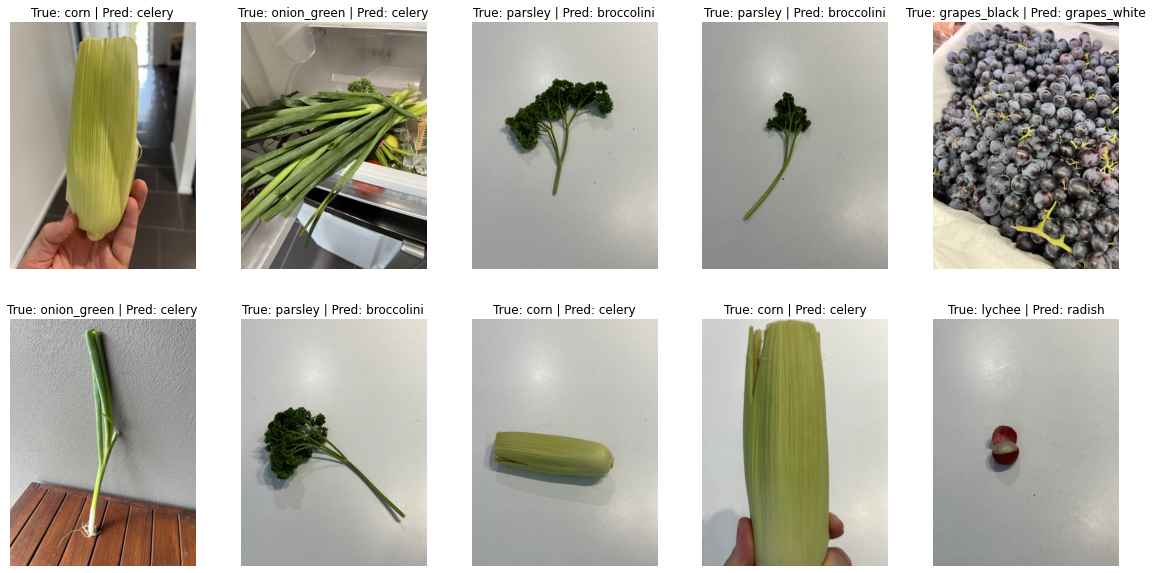

In [22]:
# Plot 10 random samples where the top 1 class name is not the true label
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i, row in enumerate(wrong_preds.sample(10).iterrows()):
    # print(row)
    row = row[1]
    # print(row)
    img = Image.open(row["image_path"])
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].set_title(f"True: {row['true_label']} | Pred: {row['avg_top_1_class_name']}")
    ax[i//5, i%5].axis("off")

In [23]:
# Get zero-shot classification for logo/no logo
logo_no_logo_zero_shot_labels = get_image_and_text_similarity_dicts(image_paths=all_paths,
                                                                    target_classes=["logo", "no_logo"])

Calculating image features and similarity dicts:   0%|          | 0/1381 [00:00<?, ?it/s]

In [24]:
# Turn list of dicts into a dataframe
logo_not_logo_df = pd.DataFrame(logo_no_logo_zero_shot_labels)
logo_not_logo_df

,image_path,blip_sorted_similarity_dict,blip_top_1_class_name,blip_top_1_similarity_score,open_clip_sorted_similarity_dict,open_clip_top_1_class_name,open_clip_top_1_similarity_score,avg_sorted_similarity_dict,avg_top_1_class_name,avg_top_1_similarity_score
0,food_photos/cashews/96237783-2f60-4f2d-983a-f1...,"{'no_logo': 0.8490176796913147, 'logo': 0.1509...",no_logo,0.849018,"{'no_logo': 0.8233283758163452, 'logo': 0.1766...",no_logo,0.823328,"{'no_logo': 0.83617302775383, 'logo': 0.163826...",no_logo,0.836173
1,food_photos/cashews/3ab541fe-7b51-4382-acaa-98...,"{'no_logo': 0.5557100176811218, 'logo': 0.4442...",no_logo,0.555710,"{'no_logo': 0.8539127111434937, 'logo': 0.1460...",no_logo,0.853913,"{'no_logo': 0.7048113644123077, 'logo': 0.2951...",no_logo,0.704811
2,food_photos/cashews/4ae82b11-052f-4b2f-b2f8-da...,"{'no_logo': 0.5084973573684692, 'logo': 0.4915...",no_logo,0.508497,"{'logo': 0.7704647779464722, 'no_logo': 0.2295...",logo,0.770465,"{'logo': 0.6309836953878403, 'no_logo': 0.3690...",logo,0.630984
3,food_photos/cashews/c6d56f23-4aee-4e35-a1a7-6b...,"{'no_logo': 0.72601717710495, 'logo': 0.273982...",no_logo,0.726017,"{'no_logo': 0.7606506943702698, 'logo': 0.2393...",no_logo,0.760651,"{'no_logo': 0.7433339357376099, 'logo': 0.2566...",no_logo,0.743334
4,food_photos/cashews/80ca8d9c-bf05-49af-84ef-6f...,"{'no_logo': 0.7572483420372009, 'logo': 0.2427...",no_logo,0.757248,"{'no_logo': 0.8807970285415649, 'logo': 0.1192...",no_logo,0.880797,"{'no_logo': 0.8190226852893829, 'logo': 0.1809...",no_logo,0.819023
...,...,...,...,...,...,...,...,...,...,...
1376,food_photos/prosciutto/3adcda2f-6bc0-495a-ae37...,"{'logo': 0.5026812553405762, 'no_logo': 0.4973...",logo,0.502681,"{'no_logo': 0.9343951344490051, 'logo': 0.0656...",no_logo,0.934395,"{'no_logo': 0.7158569544553757, 'logo': 0.2841...",no_logo,0.715857
1377,food_photos/ice_coffee/c1ab14a3-9ebe-418e-9724...,"{'logo': 0.6477257609367371, 'no_logo': 0.3522...",logo,0.647726,"{'no_logo': 0.8774768114089966, 'logo': 0.1225...",no_logo,0.877477,"{'no_logo': 0.614875540137291, 'logo': 0.38512...",no_logo,0.614876
1378,food_photos/ice_coffee/f127961a-5444-4041-b0fd...,"{'logo': 0.7617493867874146, 'no_logo': 0.2382...",logo,0.761749,"{'no_logo': 0.9736446738243103, 'logo': 0.0263...",no_logo,0.973645,"{'no_logo': 0.6059476509690285, 'logo': 0.3940...",no_logo,0.605948
1379,food_photos/ice_coffee/1e3ead6d-71fe-4ebf-af09...,"{'no_logo': 0.5146018266677856, 'logo': 0.4853...",no_logo,0.514602,"{'no_logo': 0.9886682629585266, 'logo': 0.0113...",no_logo,0.988668,"{'no_logo': 0.7516350448131561, 'logo': 0.2483...",no_logo,0.751635


<AxesSubplot:>

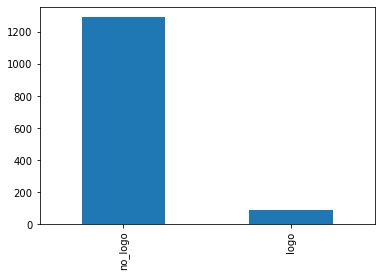

In [25]:
logo_not_logo_df.avg_top_1_class_name.value_counts().plot(kind="bar")

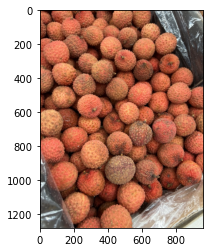

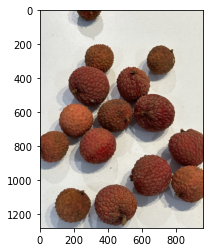

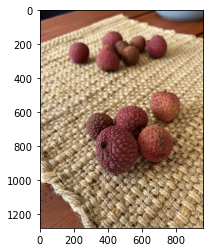

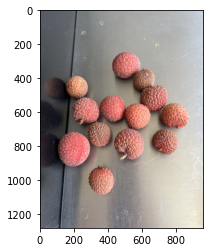

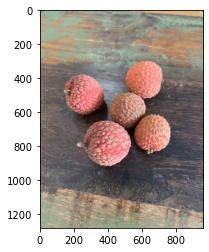

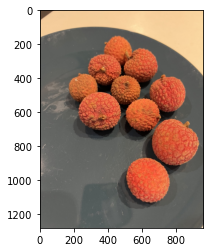

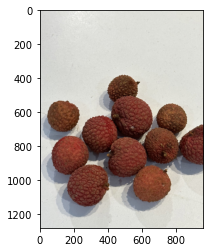

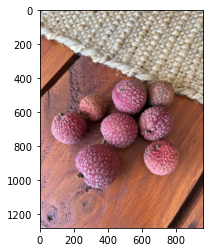

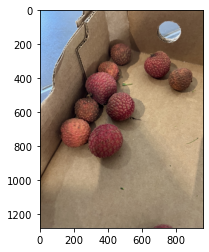

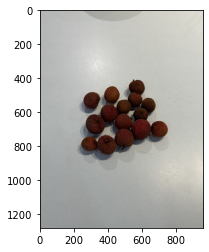

In [26]:
# Plot 10 random images where blip_top_1_class_name == "logo"
logo_samples = logo_not_logo_df[logo_not_logo_df["avg_top_1_class_name"] == "logo"].sample(10)

# Plot 10 images from the logo samples
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for row in logo_samples.iterrows():
    img = mpimg.imread(row[1]["image_path"])
    imgplot = plt.imshow(img)
    plt.show()

## Practice BLIP zero-shot on a single image

See the source: https://github.com/salesforce/LAVIS/blob/main/examples/blip_zero_shot_classification.ipynb

In [27]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
model, vis_processors, _ = load_model_and_preprocess("blip_feature_extractor", model_type="base", is_eval=True, device=device)

In [29]:
cls_names = ["edible_food", "other"]

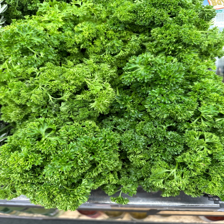

In [30]:
# Open a random image from all_paths
import random
image_path = random.choice(all_paths)
raw_image = Image.open(image_path).convert("RGB")
display(raw_image.resize((224, 224)))

In [31]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
image_features = model.extract_features({"image": image}, mode="image").image_embeds_proj[:, 0]

In [32]:
def blip_get_text_features_for_zero_shot_classification(text:list,
                                                        model=blip_feature_extractor_model):
    text_features = model.extract_features({"text_input": text}, mode="text").text_embeds_proj[:, 0]
    return text_features

text_features = blip_get_text_features_for_zero_shot_classification(["food", "not_food"])
text_features.shape

torch.Size([2, 256])

In [33]:
def blip_zero_shot_classification(image_features, text_features, class_names, blip_model=blip_feature_extractor_model):
    similarity_values = (image_features @ text_features.T)[0] / blip_model.temp
    probabilities = torch.softmax(similarity_values, dim=0).tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    return class_name_similarity_probability_dict

## Practice CLIP zero-shot on a single image

In [34]:
clip_feature_extractor_model, clip_vis_processors, clip_txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-L-14", is_eval=True, device=device)

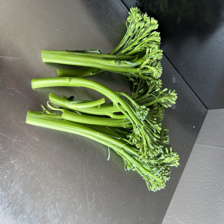

In [35]:
# Open a random image from all_paths
import random
image_path = random.choice(all_paths)
raw_image = Image.open(image_path).convert("RGB")
display(raw_image.resize((224, 224)))

In [36]:
# Process image
image = clip_vis_processors["eval"](raw_image).unsqueeze(0).to(device)
clip_image_features = clip_feature_extractor_model.extract_features({"image": image})
clip_image_features.shape

torch.Size([1, 768])

In [37]:
def clip_get_text_features_for_zero_shot_classification(text:list,
                                                        model=clip_feature_extractor_model):
    features = model.extract_features({"text_input": text})
    return features

class_names = ["edible_food", "other"]
clip_text_features = clip_get_text_features_for_zero_shot_classification(class_names)
clip_text_features.shape

torch.Size([2, 768])

In [38]:
def clip_zero_shot_classification(image_features, text_features, class_names, clip_model=clip_feature_extractor_model):
    similarity_values = (image_features @ text_features.T)[0] / 0.01
    probabilities = torch.softmax(similarity_values, dim=0).tolist()

    # Create a dict of class names and their probabilities
    class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    return class_name_similarity_probability_dict

In [39]:
clip_zero_shot_classification(clip_image_features, clip_text_features, class_names)

{'edible_food': 1.0, 'other': 0.0}

## Try OpenCLIP for zero-shot classification

See: https://github.com/mlfoundations/open_clip 

And a notebook example: https://colab.research.google.com/github/mlfoundations/open_clip/blob/master/docs/Interacting_with_open_clip.ipynb 

In [46]:
import open_clip
open_clip.list_pretrained()

[('RN50', 'openai'),
 ('RN50', 'yfcc15m'),
 ('RN50', 'cc12m'),
 ('RN50-quickgelu', 'openai'),
 ('RN50-quickgelu', 'yfcc15m'),
 ('RN50-quickgelu', 'cc12m'),
 ('RN101', 'openai'),
 ('RN101', 'yfcc15m'),
 ('RN101-quickgelu', 'openai'),
 ('RN101-quickgelu', 'yfcc15m'),
 ('RN50x4', 'openai'),
 ('RN50x16', 'openai'),
 ('RN50x64', 'openai'),
 ('ViT-B-32', 'openai'),
 ('ViT-B-32', 'laion400m_e31'),
 ('ViT-B-32', 'laion400m_e32'),
 ('ViT-B-32', 'laion2b_e16'),
 ('ViT-B-32', 'laion2b_s34b_b79k'),
 ('ViT-B-32-quickgelu', 'openai'),
 ('ViT-B-32-quickgelu', 'laion400m_e31'),
 ('ViT-B-32-quickgelu', 'laion400m_e32'),
 ('ViT-B-16', 'openai'),
 ('ViT-B-16', 'laion400m_e31'),
 ('ViT-B-16', 'laion400m_e32'),
 ('ViT-B-16', 'laion2b_s34b_b88k'),
 ('ViT-B-16-plus-240', 'laion400m_e31'),
 ('ViT-B-16-plus-240', 'laion400m_e32'),
 ('ViT-L-14', 'openai'),
 ('ViT-L-14', 'laion400m_e31'),
 ('ViT-L-14', 'laion400m_e32'),
 ('ViT-L-14', 'laion2b_s32b_b82k'),
 ('ViT-L-14-336', 'openai'),
 ('ViT-H-14', 'laion2b_s32b_

In [66]:
import torch
from PIL import Image
import open_clip
from tqdm.auto import tqdm

open_clip_model_name = "ViT-H-14"
open_clip_pretrained = "laion2b_s32b_b79k"

# open_clip_model_name = 'convnext_large_d' 
# open_clip_pretrained = 'laion2b_s26b_b102k_augreg'

# open_clip_model_name = 'ViT-g-14'
# open_clip_pretrained = 'laion2b_s12b_b42k'

def create_open_clip_model_and_preprocess(model_name: str, pretrained: str, device: torch.device):
    open_clip_model, _, open_clip_preprocess = open_clip.create_model_and_transforms(model_name=model_name, pretrained=pretrained)
    open_clip_model.to(device)

    # Get the tokenizer
    open_clip_tokenizer = open_clip.get_tokenizer(model_name)

    return open_clip_model, open_clip_preprocess, open_clip_tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
open_clip_model, open_clip_preprocess, open_clip_tokenizer = create_open_clip_model_and_preprocess(open_clip_model_name, open_clip_pretrained, device)

def open_clip_compute_image_features_of_list(image_paths: list,
                                             open_clip_model=open_clip_model,
                                             open_clip_preprocess=open_clip_preprocess,
                                             device=device):
    image_features_list = []                                    
    for image_path in tqdm(image_paths, desc="Computing OpenCLIP image features"):
        image_feature_dict = {}

        image = open_clip_preprocess(Image.open(image_path)).unsqueeze(0)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = open_clip_model.encode_image(image.to(device))
            image_features /= image_features.norm(dim=-1, keepdim=True)       

        # Append image_path to dict
        image_feature_dict["image_path"] = image_path
        image_feature_dict["image_features"] = image_features
        image_features_list.append(image_feature_dict)
    
    return image_features_list

def open_clip_compute_text_features(text: list,
                                    open_clip_model=open_clip_model,
                                    open_clip_tokenizer=open_clip_tokenizer,
                                    device=device):

    text = open_clip_tokenizer(text)

    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = open_clip_model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features

def open_clip_zero_shot_classification(image_features, text_features, class_names, device=device, sorted=True):
    # Send features to device
    image_features = image_features.to(device)
    text_features = text_features.to(device)

    with torch.no_grad(), torch.cuda.amp.autocast():
        similarity_values = (image_features @ text_features.T)[0] / 0.01
        probabilities = torch.softmax(similarity_values, dim=-1).cpu().tolist() # return values to CPU

        # Create a dict of class names and their probabilities
        class_name_similarity_probability_dict = dict(zip(class_names, probabilities))

    if sorted:
        return sort_dict_by_values(class_name_similarity_probability_dict)
    else:
        return class_name_similarity_probability_dict

In [67]:
# Check the number of parameters in open_clip_model
sum(p.numel() for p in open_clip_model.parameters())

986109441

In [68]:
# Check the number of parameters in open_clip_model
sum(p.numel() for p in open_clip_model.parameters())

986109441

In [69]:
# Check the number of parameters in open_clip_model
sum(p.numel() for p in open_clip_model.parameters())

986109441

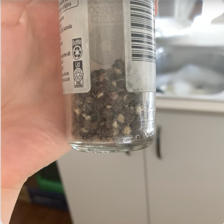

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

{'pepper': 0.9710848927497864,
 'salt': 0.028869593515992165,
 'other': 4.5486664021154866e-05}

In [70]:
# Randomly select an image from all_paths
import random
import glob
# all_paths = glob.glob("food_photos/*/*.jpeg")
# image_path = random.choice(all_paths)
image_path = "pepper-image.png"
display(Image.open(image_path).resize((224, 224)))

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

class_names = ["salt", "pepper", "other"]
open_clip_image_feature_list = open_clip_compute_image_features_of_list([image_path])
bread_text_features = open_clip_compute_text_features(class_names)
open_clip_zero_shot_classification(image_features=open_clip_image_feature_list[0]["image_features"],
                                   text_features=bread_text_features,
                                   class_names=class_names)

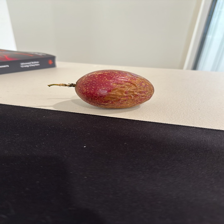

Computing OpenCLIP image features:   0%|          | 0/1 [00:00<?, ?it/s]

{'passionfruit': 0.931300699710846,
 'tamarillo': 0.03499944880604744,
 'lychee': 0.024433549493551254,
 'pomegranate': 0.004449679981917143,
 'plum': 0.0012949308147653937,
 'kiwi_fruit': 0.0008231080719269812,
 'dragonfruit': 0.0007263903389684856,
 'guava': 0.0003710038145072758,
 'mango': 0.00017253281839657575,
 'nectarines': 0.00017253281839657575,
 'onion_red': 0.00015956677088979632,
 'grapes_red': 0.0001302346063312143,
 'figs': 0.0001242707367055118,
 'beetroot': 0.00011857995559694245,
 'pear': 0.00010142681276192889,
 'apple_red': 9.235016477759928e-05,
 'tomato': 8.408578287344426e-05,
 'pawpaw': 6.548607780132443e-05,
 'mandarin': 5.870133827556856e-05,
 'avocado': 5.6895281886681914e-05,
 'chilli': 3.849727363558486e-05,
 'peach': 2.7298656277707778e-05,
 'taro': 2.7298656277707778e-05,
 'eggplant': 1.9357645214768127e-05,
 'grapefruit': 1.6048052202677354e-05,
 'turnip': 1.5313158655771986e-05,
 'ham': 1.4842023119854275e-05,
 'dates': 1.3726625184062868e-05,
 'potato_b

In [71]:
# Randomly select an image from all_paths
import random
import glob
# all_paths = glob.glob("food_photos/*/*.jpeg")
# image_path = random.choice(all_paths)
image_path = "5FD62C55-08D7-48F8-BF76-7CBA8BE0A6C7.jpeg"
display(Image.open(image_path).resize((224, 224)))

# import class_dict.json 
import json
with open("class_dict.json", "r") as f:
    class_dict = json.load(f)

class_names = class_dict.values()

# class_names = ["passionfruit", "other"]
open_clip_image_feature_list = open_clip_compute_image_features_of_list([image_path])
open_clip_text_features = open_clip_compute_text_features(class_names)
open_clip_zero_shot_classification(image_features=open_clip_image_feature_list[0]["image_features"],
                                   text_features=open_clip_text_features,
                                   class_names=class_names)

In [43]:
class_dict

{'0': 'almond_butter',
 '1': 'almonds',
 '2': 'apple_green',
 '3': 'apple_red',
 '4': 'apricot',
 '5': 'asparagus',
 '6': 'avocado',
 '7': 'bacon',
 '8': 'bacon_and_egg_burger',
 '9': 'bagel',
 '10': 'baklava',
 '11': 'banana',
 '12': 'banana_bread',
 '13': 'barbecue_sauce',
 '14': 'beans',
 '15': 'beef',
 '16': 'beef_curry',
 '17': 'beef_mince',
 '18': 'beef_stir_fry',
 '19': 'beer',
 '20': 'beetroot',
 '21': 'biltong',
 '22': 'blackberries',
 '23': 'blueberries',
 '24': 'bok_choy',
 '25': 'bread',
 '26': 'bread_naan',
 '27': 'broccoli',
 '28': 'broccolini',
 '29': 'brownie',
 '30': 'brussel_sprouts',
 '31': 'burrito',
 '32': 'butter',
 '33': 'cabbage',
 '34': 'calamari',
 '35': 'candy',
 '36': 'capsicum',
 '37': 'carrot',
 '38': 'cashews',
 '39': 'cauliflower',
 '40': 'celery',
 '41': 'cheese',
 '42': 'cheeseburger',
 '43': 'cherries',
 '44': 'chicken_breast',
 '45': 'chicken_thighs',
 '46': 'chicken_wings',
 '47': 'chilli',
 '48': 'chimichurri',
 '49': 'chocolate',
 '50': 'chocolate